In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import numpy as np
import pywt
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt

#변수 설정

In [2]:
DATA_POINTS_PER_FILE = 2560
TIME_PER_REC = 0.1
SAMPLING_FREQ = 25600 # 25.6 KHz
SAMPLING_PERIOD = 1.0/SAMPLING_FREQ

WIN_SIZE = 20

WAVELET_TYPE = 'morl'
  
VAL_SPLIT = 0.1
 
np.random.seed(1234)

(1) 만들어진 피클파일 train 데이터셋을 로드

(2) 연속 웨이블릿 변환 적용

(3) 데이터 정규화

In [3]:
def load_df(pkz_file):
    with open(pkz_file, 'rb') as f:
        df=pkl.load(f)
    return df

In [4]:
def df_row_ind_to_data_range(ind):
    return (DATA_POINTS_PER_FILE*ind, DATA_POINTS_PER_FILE*(ind+1))

In [5]:
def extract_feature_image(ind, feature_name='horiz accel'):
    data_range = df_row_ind_to_data_range(ind)
    data = df[feature_name].values[data_range[0]:data_range[1]]

    data = np.array([np.mean(data[i:i+WIN_SIZE]) for i in range(0, DATA_POINTS_PER_FILE, WIN_SIZE)])

    coef, _ = pywt.cwt(data, np.linspace(1,128,128), WAVELET_TYPE)

    coef = np.log2(coef**2+0.001)

    coef = (coef - coef.min())/(coef.max() - coef.min()) 
    return coef

#메인 디렉토리 폴더 경로

In [6]:
main_dir = '/home/i4624/vscode/gitclone/SWbootProject_2023-7/Team-project/data/ieee-phm-2012-data-challenge-dataset-master/Learning_set/'

#Bearing1_1

In [7]:
pkz_file = main_dir + 'bearing1_1.pkz'
df = load_df(pkz_file)
df.head()

hour  minute  second  microsecond  horiz accel  vert accel
0     9      39      39      65664.0        0.552      -0.146
1     9      39      39      65703.0        0.501      -0.480
2     9      39      39      65742.0        0.138       0.435
3     9      39      39      65781.0       -0.423       0.240
4     9      39      39      65820.0       -0.802       0.020

In [8]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

7175680 2803


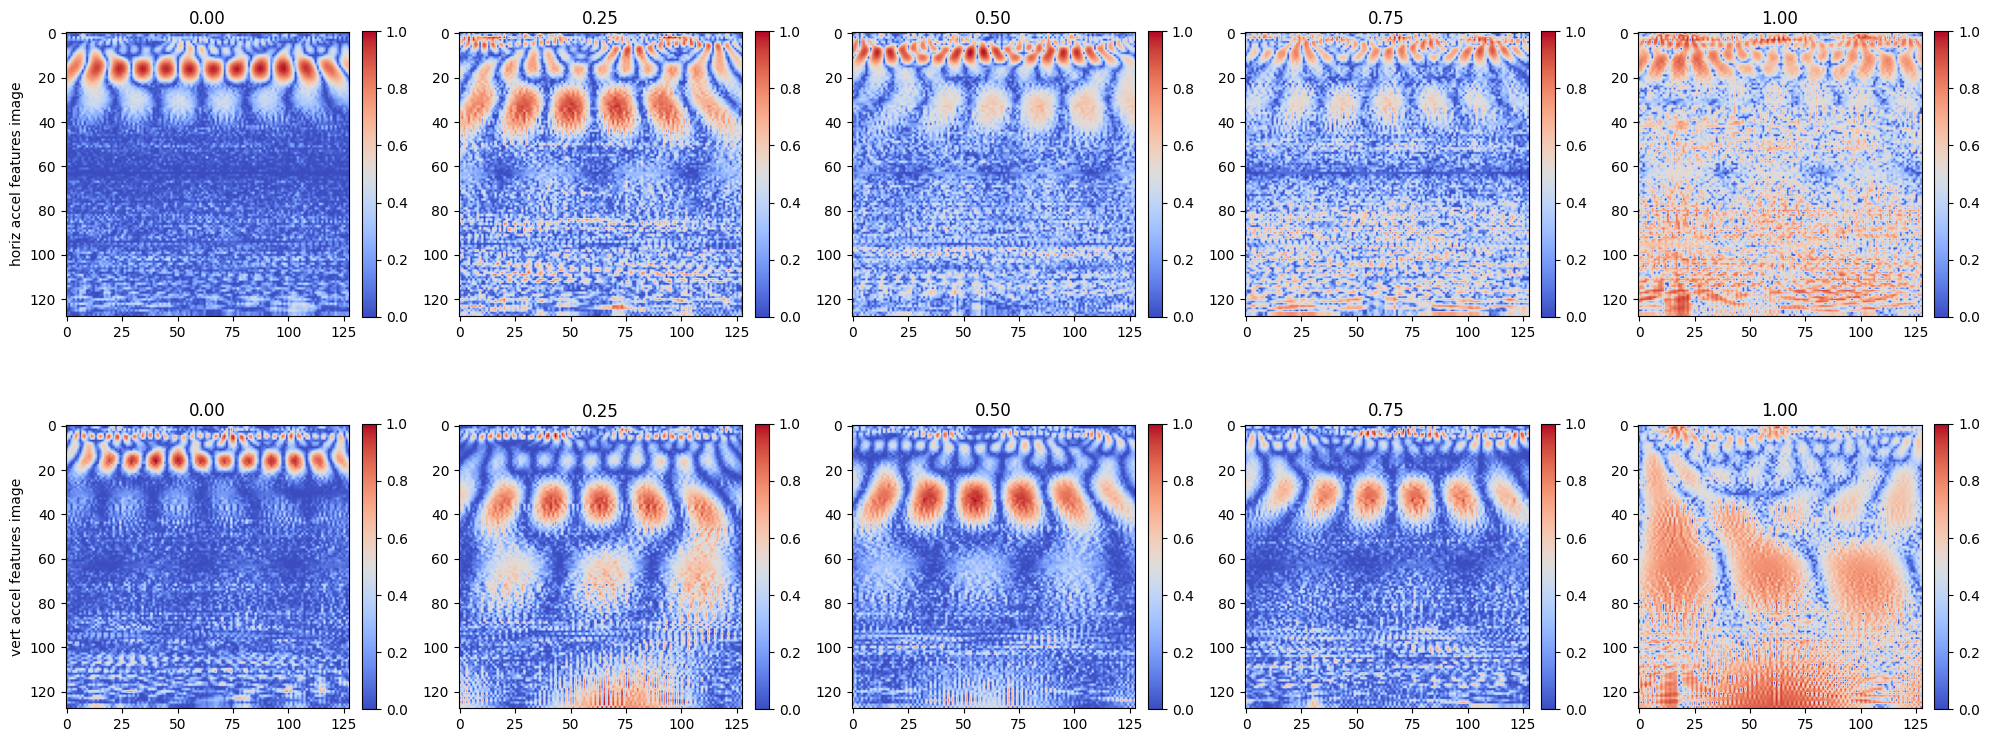

In [9]:
no_of_samples=5
fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
ax[0,0].set_ylabel('horiz accel features image')
ax[1,0].set_ylabel('vert accel features image')

for i, p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int((no_of_files-1)*p)

    coef = extract_feature_image(ind, feature_name='horiz accel')
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)
  
    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)
  
plt.tight_layout()
plt.show()

#베어링1_1의 각 데이터 파일에서 2D 특성 이미지를 추출 및 numpy 배열로 변환 후 고장 확률 저장

In [10]:
data = {'x': [], 'y': []}
for i in range(0, no_of_files):
    coef_h = extract_feature_image(i, feature_name='horiz accel')
    coef_v = extract_feature_image(i, feature_name='vert accel')
    x_ = np.array([coef_h, coef_v])
    y_ = i/(no_of_files-1)
    data['x'].append(x_)
    data['y'].append(y_)
data['x']=np.array(data['x'])
data['y']=np.array(data['y'])

assert data['x'].shape==(no_of_files, 2, 128, 128)
print(no_of_files, data['x'].shape, data['y'].shape)

2803 (2803, 2, 128, 128) (2803,)


#(2) 훈련데이터와 검증데이터로 분리

In [11]:
no_of_val = int(VAL_SPLIT*no_of_files)
perm = np.random.permutation(no_of_files)
val_data = {'x': data['x'][perm[0:no_of_val]], 'y': data['y'][perm[0:no_of_val]]}
train_data = {'x': data['x'][perm[no_of_val: ]], 'y': data['y'][perm[no_of_val: ]]}

print(no_of_val, val_data['x'].shape, val_data['y'].shape)
print(no_of_files-no_of_val, train_data['x'].shape, train_data['y'].shape)

280 (280, 2, 128, 128) (280,)
2523 (2523, 2, 128, 128) (2523,)


#(3)pkz 파일로 저장

In [ ]:
out_file = main_dir + 'bearing1_1_val_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(val_data, f)

out_file = main_dir + 'bearing1_1_train_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(train_data, f)

#Bearing1_2

In [ ]:
pkz_file = main_dir + 'bearing1_2.pkz'
df = load_df(pkz_file)
df.head()

hour  minute  second  microsecond  horiz accel  vert accel
0     8      47       5     196910.0        0.050      -0.253
1     8      47       5     196950.0        0.165      -0.140
2     8      47       5     196990.0        0.125       0.542
3     8      47       5     197030.0        0.157      -0.261
4     8      47       5     197070.0        0.421       0.081

In [ ]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

2229760 871


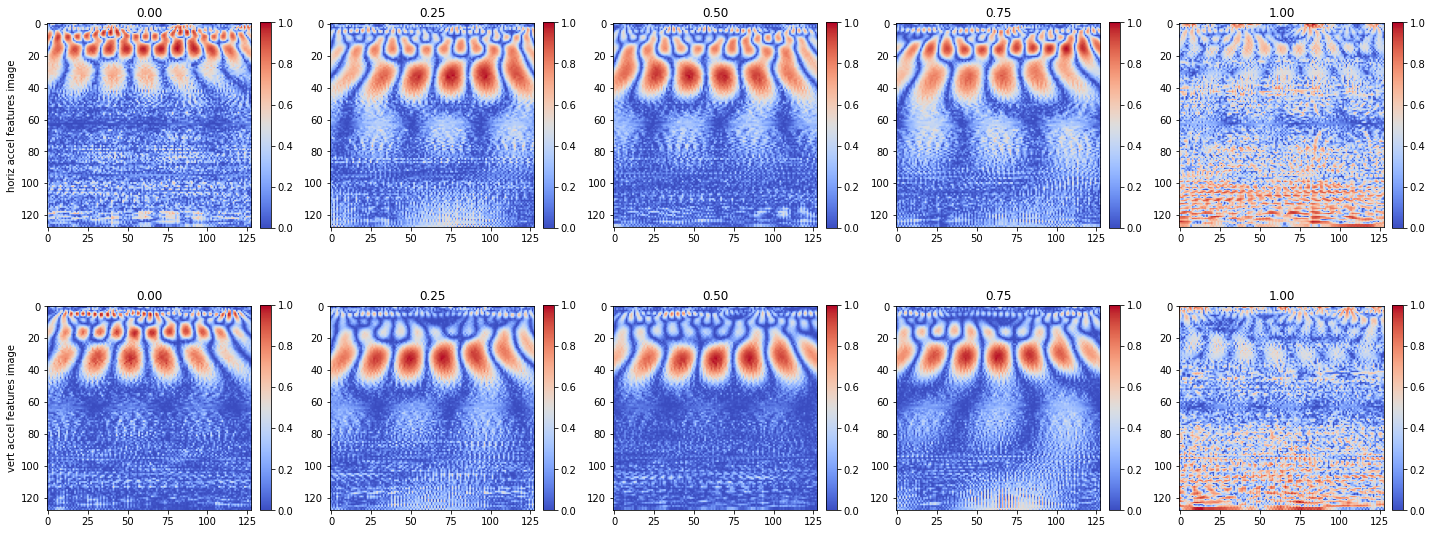

In [ ]:
no_of_samples=5
fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
ax[0,0].set_ylabel('horiz accel features image')
ax[1,0].set_ylabel('vert accel features image')

for i, p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int((no_of_files-1)*p)

    coef = extract_feature_image(ind, feature_name='horiz accel')
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)

    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.show()

In [ ]:
data = {'x': [], 'y': []}
for i in range(0, no_of_files):
    coef_h = extract_feature_image(i, feature_name='horiz accel')
    coef_v = extract_feature_image(i, feature_name='vert accel')
    x_ = np.array([coef_h, coef_v])
    y_ = i/(no_of_files-1)
    data['x'].append(x_)
    data['y'].append(y_)
data['x']=np.array(data['x'])
data['y']=np.array(data['y'])

assert data['x'].shape==(no_of_files, 2, 128, 128)
print(no_of_files, data['x'].shape, data['y'].shape)

871 (871, 2, 128, 128) (871,)


In [ ]:
no_of_val = int(VAL_SPLIT*no_of_files)
perm = np.random.permutation(no_of_files)
val_data = {'x': data['x'][perm[0:no_of_val]], 'y': data['y'][perm[0:no_of_val]]}
train_data = {'x': data['x'][perm[no_of_val: ]], 'y': data['y'][perm[no_of_val: ]]}

print(no_of_val, val_data['x'].shape, val_data['y'].shape)
print(no_of_files-no_of_val, train_data['x'].shape, train_data['y'].shape)

87 (87, 2, 128, 128) (87,)
784 (784, 2, 128, 128) (784,)


In [ ]:
out_file = main_dir + 'bearing1_2_val_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(val_data, f)


out_file = main_dir + 'bearing1_2_train_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(train_data, f)

#Bearing2_1

In [ ]:
pkz_file = main_dir + 'bearing2_1.pkz'
df = load_df(pkz_file)
df.head()

hour  minute  second  microsecond  horiz accel  vert accel
0     8      14      15     884410.0       -0.391       0.011
1     8      14      15     884450.0        0.292       0.133
2     8      14      15     884490.0        0.596       0.024
3     8      14      15     884530.0        0.230       0.272
4     8      14      15     884570.0       -0.225       0.272

In [ ]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

2332160 911


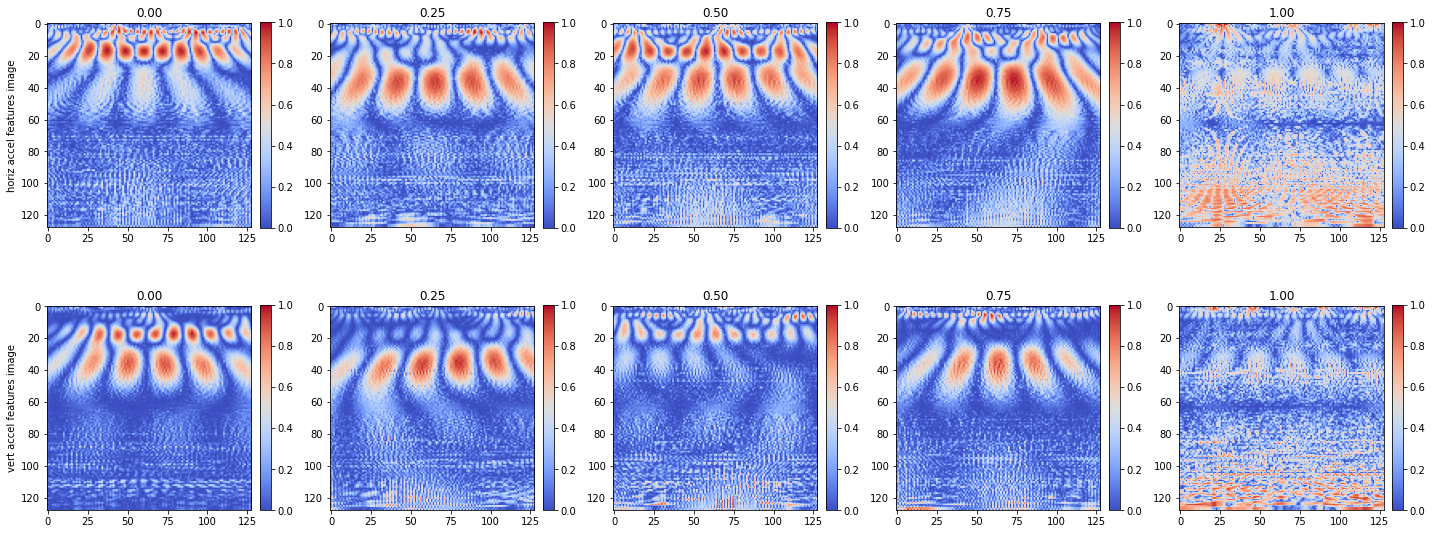

In [ ]:
no_of_samples=5
fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
ax[0,0].set_ylabel('horiz accel features image')
ax[1,0].set_ylabel('vert accel features image')

for i, p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int((no_of_files-1)*p)

    coef = extract_feature_image(ind, feature_name='horiz accel')
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)

    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.show()

In [ ]:
data = {'x': [], 'y': []}
for i in range(0, no_of_files):
    coef_h = extract_feature_image(i, feature_name='horiz accel')
    coef_v = extract_feature_image(i, feature_name='vert accel')
    x_ = np.array([coef_h, coef_v])
    y_ = i/(no_of_files-1)
    data['x'].append(x_)
    data['y'].append(y_)
data['x']=np.array(data['x'])
data['y']=np.array(data['y'])

assert data['x'].shape==(no_of_files, 2, 128, 128)
print(no_of_files, data['x'].shape, data['y'].shape)

911 (911, 2, 128, 128) (911,)


In [ ]:
no_of_val = int(VAL_SPLIT*no_of_files)
perm = np.random.permutation(no_of_files)
val_data = {'x': data['x'][perm[0:no_of_val]], 'y': data['y'][perm[0:no_of_val]]}
train_data = {'x': data['x'][perm[no_of_val: ]], 'y': data['y'][perm[no_of_val: ]]}

print(no_of_val, val_data['x'].shape, val_data['y'].shape)
print(no_of_files-no_of_val, train_data['x'].shape, train_data['y'].shape)

91 (91, 2, 128, 128) (91,)
820 (820, 2, 128, 128) (820,)


In [ ]:
out_file = main_dir + 'bearing2_1_val_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(val_data, f)


out_file = main_dir + 'bearing2_1_train_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(train_data, f)

#Bearing2_2

In [ ]:
pkz_file = main_dir + 'bearing2_2.pkz'
df = load_df(pkz_file)
df.head()

hour  minute  second  microsecond  horiz accel  vert accel
0     7      40      33     540660.0        0.038       0.290
1     7      40      33     540700.0        0.125      -0.104
2     7      40      33     540740.0        0.035      -0.314
3     7      40      33     540780.0       -0.092       0.200
4     7      40      33     540820.0        0.033       0.211

In [ ]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

2040320 797


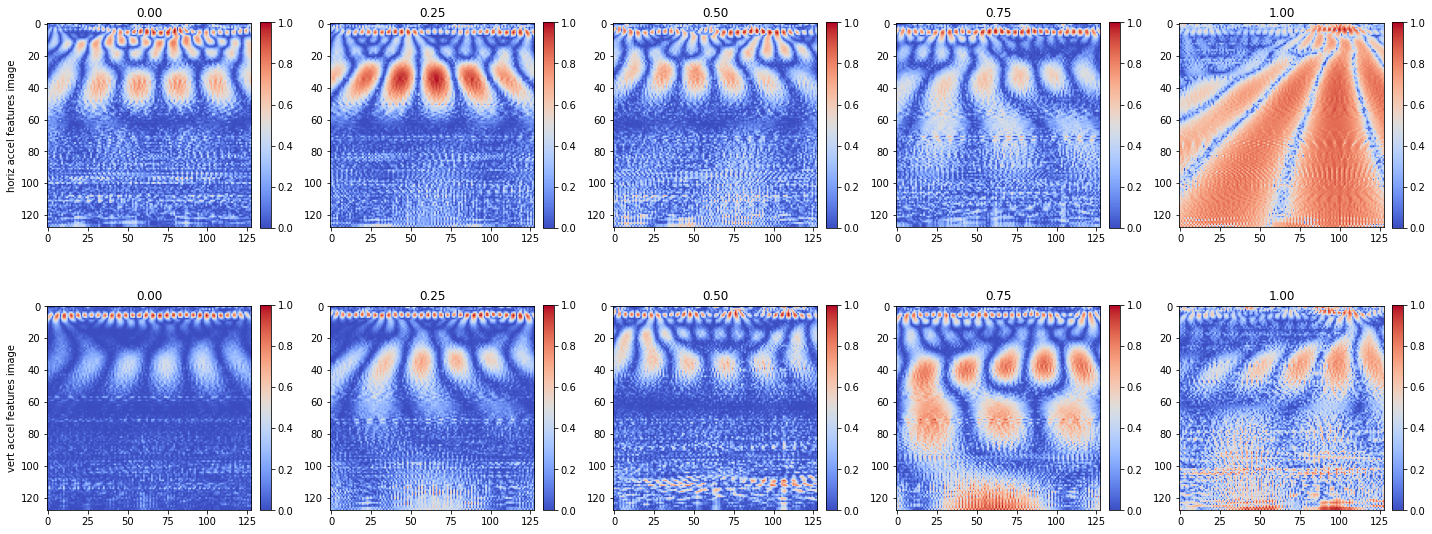

In [ ]:
no_of_samples=5
fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
ax[0,0].set_ylabel('horiz accel features image')
ax[1,0].set_ylabel('vert accel features image')

for i, p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int((no_of_files-1)*p)

    coef = extract_feature_image(ind, feature_name='horiz accel')
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)

    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.show()

In [ ]:
data = {'x': [], 'y': []}
for i in range(0, no_of_files):
    coef_h = extract_feature_image(i, feature_name='horiz accel')
    coef_v = extract_feature_image(i, feature_name='vert accel')
    x_ = np.array([coef_h, coef_v])
    y_ = i/(no_of_files-1)
    data['x'].append(x_)
    data['y'].append(y_)
data['x']=np.array(data['x'])
data['y']=np.array(data['y'])

assert data['x'].shape==(no_of_files, 2, 128, 128)
print(no_of_files, data['x'].shape, data['y'].shape)

797 (797, 2, 128, 128) (797,)


In [ ]:
no_of_val = int(VAL_SPLIT*no_of_files)
perm = np.random.permutation(no_of_files)
val_data = {'x': data['x'][perm[0:no_of_val]], 'y': data['y'][perm[0:no_of_val]]}
train_data = {'x': data['x'][perm[no_of_val: ]], 'y': data['y'][perm[no_of_val: ]]}

print(no_of_val, val_data['x'].shape, val_data['y'].shape)
print(no_of_files-no_of_val, train_data['x'].shape, train_data['y'].shape)

79 (79, 2, 128, 128) (79,)
718 (718, 2, 128, 128) (718,)


In [ ]:
out_file = main_dir + 'bearing2_2_val_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(val_data, f)


out_file = main_dir + 'bearing2_2_train_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(train_data, f)

#Bearing3_1

In [ ]:
pkz_file = main_dir + 'bearing3_1.pkz'
df = load_df(pkz_file)
df.head()

hour  minute  second  microsecond  horiz accel  vert accel
0     9      10      39     118790.0        0.338      -0.263
1     9      10      39     118830.0        0.278       0.285
2     9      10      39     118870.0        0.143       0.590
3     9      10      39     118910.0        0.090      -0.193
4     9      10      39     118940.0        0.035      -0.109

In [ ]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

1318400 515


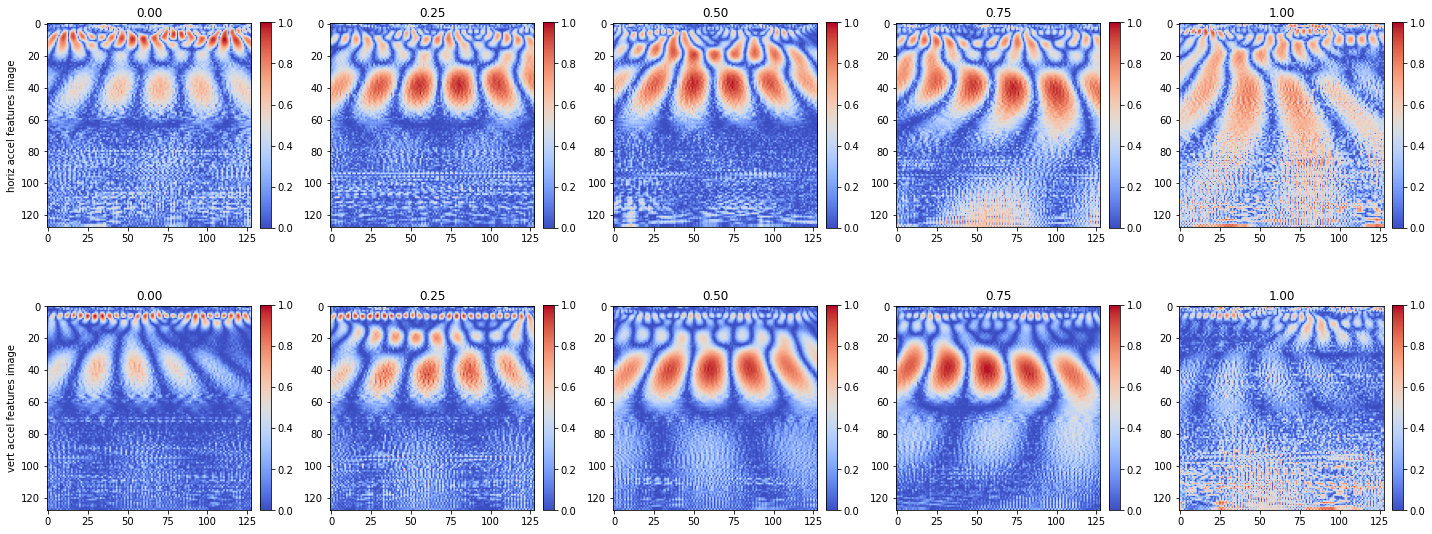

In [ ]:
no_of_samples=5
fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
ax[0,0].set_ylabel('horiz accel features image')
ax[1,0].set_ylabel('vert accel features image')

for i, p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int((no_of_files-1)*p)

    coef = extract_feature_image(ind, feature_name='horiz accel')
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)

    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.show()

In [ ]:
data = {'x': [], 'y': []}
for i in range(0, no_of_files):
    coef_h = extract_feature_image(i, feature_name='horiz accel')
    coef_v = extract_feature_image(i, feature_name='vert accel')
    x_ = np.array([coef_h, coef_v])
    y_ = i/(no_of_files-1)
    data['x'].append(x_)
    data['y'].append(y_)
data['x']=np.array(data['x'])
data['y']=np.array(data['y'])

assert data['x'].shape==(no_of_files, 2, 128, 128)
print(no_of_files, data['x'].shape, data['y'].shape)

515 (515, 2, 128, 128) (515,)


In [ ]:
no_of_val = int(VAL_SPLIT*no_of_files)
perm = np.random.permutation(no_of_files)
val_data = {'x': data['x'][perm[0:no_of_val]], 'y': data['y'][perm[0:no_of_val]]}
train_data = {'x': data['x'][perm[no_of_val: ]], 'y': data['y'][perm[no_of_val: ]]}

print(no_of_val, val_data['x'].shape, val_data['y'].shape)
print(no_of_files-no_of_val, train_data['x'].shape, train_data['y'].shape)

51 (51, 2, 128, 128) (51,)
464 (464, 2, 128, 128) (464,)


In [ ]:
out_file = main_dir + 'bearing3_1_val_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(val_data, f)


out_file = main_dir + 'bearing3_1_train_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(train_data, f)

#Bearing3_2

In [ ]:
pkz_file = main_dir + 'bearing3_2.pkz'
df = load_df(pkz_file)
df.head()

hour  minute  second  microsecond  horiz accel  vert accel
0     8      34      41     978160.0       -0.291       0.181
1     8      34      41     978200.0        0.146       0.185
2     8      34      41     978240.0        0.404      -0.159
3     8      34      41     978280.0        0.191      -0.179
4     8      34      41     978320.0       -0.180       0.072

In [ ]:
no_of_rows = df.shape[0]
no_of_files = int(no_of_rows / DATA_POINTS_PER_FILE)
print(no_of_rows, no_of_files)

4190720 1637


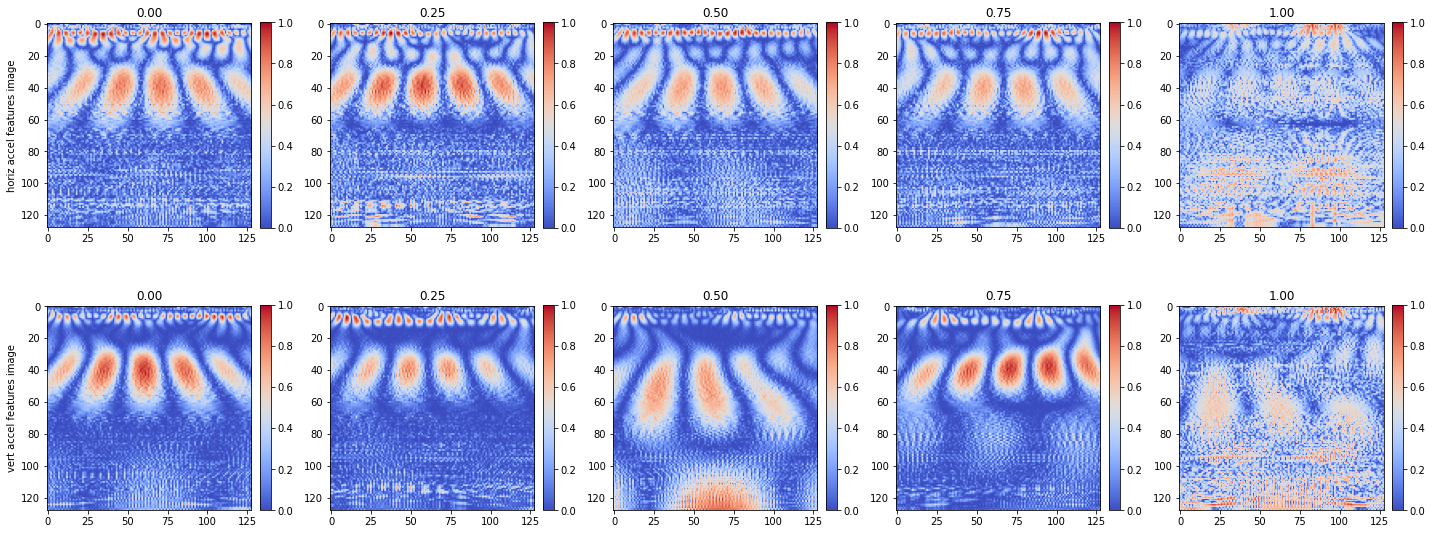

In [ ]:
no_of_samples=5
fig, ax = plt.subplots(2, no_of_samples, figsize=[20,8])
ax[0,0].set_ylabel('horiz accel features image')
ax[1,0].set_ylabel('vert accel features image')

for i, p in enumerate(np.linspace(0,1,no_of_samples)):
    ind = int((no_of_files-1)*p)

    coef = extract_feature_image(ind, feature_name='horiz accel')
    ax[0,i].set_title('{0:.2f}'.format(p))
    im = ax[0,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[0,i], fraction=0.046, pad=0.04)

    coef = extract_feature_image(ind, feature_name='vert accel')
    ax[1,i].set_title('{0:.2f}'.format(p))
    im = ax[1,i].imshow(coef, cmap='coolwarm')
    fig.colorbar(im, ax=ax[1,i], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.show()

In [ ]:
data = {'x': [], 'y': []}
for i in range(0, no_of_files):
    coef_h = extract_feature_image(i, feature_name='horiz accel')
    coef_v = extract_feature_image(i, feature_name='vert accel')
    x_ = np.array([coef_h, coef_v])
    y_ = i/(no_of_files-1)
    data['x'].append(x_)
    data['y'].append(y_)
data['x']=np.array(data['x'])
data['y']=np.array(data['y'])

assert data['x'].shape==(no_of_files, 2, 128, 128)
print(no_of_files, data['x'].shape, data['y'].shape)

1637 (1637, 2, 128, 128) (1637,)


In [ ]:
no_of_val = int(VAL_SPLIT*no_of_files)
perm = np.random.permutation(no_of_files)
val_data = {'x': data['x'][perm[0:no_of_val]], 'y': data['y'][perm[0:no_of_val]]}
train_data = {'x': data['x'][perm[no_of_val: ]], 'y': data['y'][perm[no_of_val: ]]}

print(no_of_val, val_data['x'].shape, val_data['y'].shape)
print(no_of_files-no_of_val, train_data['x'].shape, train_data['y'].shape)

163 (163, 2, 128, 128) (163,)
1474 (1474, 2, 128, 128) (1474,)


In [ ]:
out_file = main_dir + 'bearing3_2_val_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(val_data, f)


out_file = main_dir + 'bearing3_2_train_data.pkz'
with open(out_file, 'wb') as f:
    pkl.dump(train_data, f)